<a href="https://colab.research.google.com/github/ericpapain/DiscriminationTweetsProject/blob/master/Bert_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Initialisation de Collab dans mon drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Import dataset and librairies**

#### *1.1 Import Librairies*

In [2]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 5.2MB/s 


In [3]:
import pandas as pd
import numpy as np
import re
from spellchecker import SpellChecker
import requests
from datetime import datetime

#### *1.2 Import dataset*

In [6]:
dataset = pd.read_csv('discrimination.csv', sep=',')

In [7]:
discriminant_Dataset = dataset.iloc[:,[1,3]]

In [8]:
discriminant_Dataset.sample

<bound method NDFrame.sample of                                                   Tweets  Labels
0      @TVBachelor @NewJerzeyBoy what about the femin...       1
1      @ThelmaSleaze uh... did you watch the video? o...       1
2      Managed to hit a bird and a small rodent on my...       1
3      If you believe a #holohoax or #gays, LGBT &amp...       1
4      Rid yourself of #Feminazi, #Fag &amp; #Jewf. E...       1
...                                                  ...     ...
22899  #MKR that wiped that horrible smile off Kat's ...       1
22900  RT @Oneiorosgrip: #adviceforyoungfeminists Lea...       1
22901  RT @Keltonsexy250 I'm concerned for the girls ...       1
22902  RT @melbsonmymind: NO. NO NO NO NO NO NO NO. G...       1
22903  A hit with 5-year-olds @adnan_bahatti55 Don't ...       1

[22904 rows x 2 columns]>

## **2. Tokenization and Input Formatting**

In [9]:
def data_cleaning(dataset):
    '''
        df : DataFrame 
    '''
    #capture du temps d'exécution du programme
    start_time = datetime.now()
    for i in range(len(dataset)):
        # Mise en minuscule 
        dataset['Tweets'][i] = dataset['Tweets'][i].lower()
        #suppression des carractère spéciaux
        dataset['Tweets'][i]=re.sub(r'(&#[0-9]*;)', ' ',dataset['Tweets'][i])
        #suppression des annotations, des noms et tag inutile
        dataset['Tweets'][i]=re.sub(r'(@.*?)[\s]', ' ',dataset['Tweets'][i])
        # Replace '&amp;' par '&'
        dataset['Tweets'][i] = re.sub(r'&amp;', '&', dataset['Tweets'][i])
        #suppression urls
        dataset['Tweets'][i]=re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' ',dataset['Tweets'][i])
        #suppression des retweets
        dataset['Tweets'][i]=re.sub(r'rt', ' ',dataset['Tweets'][i])
        # Suppression des espaces de fin de ligne
        dataset['Tweets'][i] = re.sub(r'\s+', ' ', dataset['Tweets'][i]).strip()
  
    #capture temps de fin
    end_time = datetime.now()
    print(">>>>> le data cleanning à pris :",(end_time-start_time)," secondes.")
    return dataset

### *- Gestion des mots ecris en verlang, argo, etc...*

In [10]:
#parcours de chaque mot dans un tweet
def remplace_word_abbreviation(dataset_clean,file_txt):
    start_time = datetime.now()
    list_word=[]
    new_list_word=[]
    dico_word_abrev={}
    #chargement du dico des abrev
    a_file = open(file_txt)
    for line in a_file:
        value = line.split(",")
        #list_word.append(value)
    for val in value:
        valN = val.strip("{}")
        list_word.append(valN)
    for val in list_word:
        valN = val.split(":")
        try:
            key = valN[0]
            val_key = valN[1]
            dico_word_abrev[key] = val_key
        except:
            #print(key, "------------------------",val_key)
            del val
            pass
    for word_dico,values in dico_word_abrev.items():
        for i in range(len(dataset_clean)):
            tweet = list((dataset_clean['Tweets'][i]).split())
            #positionnement au premier mot
            j=0
            for word in tweet:
                #recupération du mot en non abrégé
                if(word == word_dico):
                    #remplacement dans le tweet
                    tweet[j]=values
                #tweet suivant
                j=j+1
            if(j==0):
                pass
            else:
                #mise a jour du tweet dans le dataset
                dataset['Tweets'][i] = ' '.join(tweet)
            #if(i==len(dataset_clean)-1):
                #print(i)
    end_time = datetime.now()
    print(">>>>> le remplacement des mots abégé et ecris en argo à pris :",(end_time-start_time)," secondes.")

    return dataset

### *- Gestion des fautes de grammaires et d'orthographe, mots mal écris etc ...*

In [11]:
#recherche de mot mal écrit
def spelling_word_in_tweet(dataset_clean):
    
    start_time = datetime.now()
    
    spell = SpellChecker(language='en',distance=1)
    dico_correction_orthographe = {}
    
    for i in range(len(dataset_clean)):
        tweet = list((dataset_clean['Tweets'][i]).split())
        j=0
        for word in tweet:
            # Get the one `most likely` answer
            #print("next : ",word," newww :",spell.correction(word))
            mot = spell.correction(word)
            # Get a list of `likely` options
           # print(spell.candidates(word))
            if(mot==word):
                pass
            else:
                #construction du dico des abréviation trouvé
                #print(mot,word)
                dico_correction_orthographe[word]=mot
                tweet[j]=mot
                #print("tweet number : ",i," i was :",word," now i'm ",true_val)
            j=j+1
            #print(r.text[startIndex:endIndex])
        if(j==0):
            pass
        else:
            #mise a jour du tweet
            dataset_clean['Tweets'][i] = ' '.join(tweet)
            dataset_clean['Tweets'][i] = dataset_clean['Tweets'][i].lower()
        #if((i+1)%len(dataset_clean)==0):
            #print(i,": tous les tweets ont été corrigé !!!")
    
    end_time = datetime.now()
    print(">>>>> le remplacement des mots mal écris ( fautes d'othographes et de grammaires) à pris :",(end_time-start_time)," secondes.")
    
    return dico_correction_orthographe, dataset

### *- Fonctions de prétraitement*
- datacleaning
- gestion abreviation
- gestion des spelling word

In [12]:
def traitemnet_before_bert_tokenization(dataset):
    #import file abrev 
    file = "dico_abrev.txt"
    # small cleaning
    dataset_clean=data_cleaning(dataset)
    # abreviation subtitution
    dataset_with_abrev_ok=remplace_word_abbreviation(dataset_clean,file)
    # manage spelling word
    _, dataset_spell_ok=spelling_word_in_tweet(dataset_with_abrev_ok)
    
    return dataset_spell_ok

## *------ Lancement du pretraitement sur notre jeu de donnée -----*

In [13]:
#small traitemnt
discriminant_Dataset = traitemnet_before_bert_tokenization(discriminant_Dataset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python

>>>>> le data cleanning à pris : 0:00:36.336909  secondes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


>>>>> le remplacement des mots abégé et ecris en argo à pris : 0:49:48.832839  secondes.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


>>>>> le remplacement des mots mal écris ( fautes d'othographes et de grammaires) à pris : 0:00:58.365109  secondes.


### *--- Division de notre jeux de donnée en jeu d'entrainement et de test ---*

In [15]:
# division de notre jeu de donnée en jeu d'entrainement et de test
discriminant_Dataset['split']= np.random.randn(discriminant_Dataset.shape[0], 1)
msk = np.random.rand(len(discriminant_Dataset)) <= 0.9
#data_train et data_test
data_train = discriminant_Dataset[msk]
data_test = discriminant_Dataset[~msk]

data_train = data_train.iloc[:,[1,3]]
data_test = data_test.iloc[:,[1,3]]

#### *Training/Validation Split*


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
#for discriminant data
X_discri_train, X_discri_val, y_discri_train, y_discri_val = train_test_split(data_train['Tweets'], 
                                                  data_train['Labels'], 
                                                  test_size=0.10, 
                                                  random_state=2020, 
                                                  stratify=data_train['Labels'])

#### *2.1. BERT Tokenizer*

In [18]:
!pip install transformers

     |████████████████████████████████| 1.5MB 6.7MB/s 
     |████████████████████████████████| 2.9MB 30.8MB/s 
     |████████████████████████████████| 890kB 50.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=35b231747f10115b40374437e48c0e1aac9621c58c7f2a275468812d7482ec18
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### *-Chargement du tokenizer de BERT*

In [19]:
from transformers import BertTokenizer
import torch
# Chargement du tokenizer de Bert
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

### *-Recherche de la chaine la plus longue dans nos tweet*

In [20]:
#extraction de nos tweets
all_tweets = dataset.Tweets.values
# Encodage de notre dataset en une liste liste pour rechercher le la chaine la plus longue de notre dataset
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# recherche du tweet le plus long
MAX_LEN = max([len(sent) for sent in encoded_tweets])
print('Max length: ', MAX_LEN)

Max length:  61


### *--Définir fonction de pré processing pour BERT en utilisant son tokenizer définie plus haut--*

In [21]:
# Fonction de tokenization de notre corpus
def preprocessing_for_bert(data_after_clean):
    
    start_time = datetime.now()
    
    # creation de liste vide pour sauvegarder les sorties ( mask et token)
    input_ids = []
    attention_masks = []

    # pour chaque phrase,
    for sent in data_after_clean:
        # `encode_plus` permet de:
        #    (1) Tokenizer les phrases
        #    (2) Ajoute les tokens `[CLS]` et `[SEP]` pour marquer le debut et la fin d'une phrase
        #    (3) Map les tokens avec leurs IDs respectifs
        #    (4) Crée le mask d'attention
        #    (5) Retourne un dictionnaire en sortie
        encoded_sent = tokenizer.encode_plus(
            sent,                           #chargement des phrases du corpus
            add_special_tokens=True,        #ajout des tokens de debut `[CLS]` et fin de ligne `[SEP]`
            max_length=MAX_LEN,             #Max lenght
            pad_to_max_length=True,         
            return_attention_mask=True      #attention mask
            )
        
        # ajout des sorties apres tokenization dans les listes créer plus haut
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Converssion des listes en tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    end_time = datetime.now()
    print(">>>>> La Tokenization à pris :",(end_time-start_time)," secondes.")
    
    return input_ids, attention_masks

### -------------Tokenization.

In [22]:
#lancememnt de la fonction `preprocessing_for_bert` sur le jeu d'entrainement et de validation pour le discriminant dataset
print('Tokenizing data...')
train_discr_inputs, train_discr_masks = preprocessing_for_bert(X_discri_train)
val_discr_inputs, val_discr_masks = preprocessing_for_bert(X_discri_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


>>>>> La Tokenization à pris : 0:00:08.416711  secondes.
>>>>> La Tokenization à pris : 0:00:00.947001  secondes.


### **2.2. Creation de notre DataLoader**

Nous allons créer ici un itérateur pour notre ensemble de données à l'aide de la classe Torch DataLoader. Cela aidera à économiser de la mémoire pendant l'entraînement et à augmenter la vitesse d'entraînement.

In [23]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification

# Pour affiner BERT, les auteurs recommandent une taille de batch de 16 ou 32, nous prendrons 32.
batch_size = 32

In [24]:
# convertion de nos label en tensors pour la manipulation par le GPU
train_discri_labels = torch.tensor(y_discri_train.values)
val_discri_labels = torch.tensor(y_discri_val.values)

# Creation de notre dataloader pour le training set pour le discrimination dataset
train_discri_data = TensorDataset(train_discr_inputs, train_discr_masks, train_discri_labels)
train_d_sampler = RandomSampler(train_discri_data)
train_discri_dataloader = DataLoader(train_discri_data, sampler=train_d_sampler, batch_size=batch_size)

# Creation de notre dataloader pour le validation set pour le discrimination dataset
val_discri_data = TensorDataset(val_discr_inputs, val_discr_masks, val_discri_labels)
val_d_sampler = SequentialSampler(val_discri_data)
val_discri_dataloader = DataLoader(val_discri_data, sampler=val_d_sampler, batch_size=batch_size)

## **3. Entrainement de notre Model**

#### *3.1. Create BertClassifier*

In [28]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model pour la classififcation implémenter avec tous les paramètres de zéro.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: le model objet de BertModel
        @param    classifier: le module reseau de neurone de pytoch torch.nn.Module
        @param    freeze_bert (bool): Set `False` pour activer ou désactiver le fine-tune du model de  BERT
        """
        super(BertClassifier, self).__init__()
        # Specifions les différentes couches et nombre d'entrée de neuronnes: hidden size pour BERT, hidden size pour notre classifier, et nombre de labels (sortie : 2 pour 0 ou 1)
        D_in, H, D_out = 768, 200, 2

        # Initialisation du model de BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # instanciation du modèle et mise en place du one-layer feedforward
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # ici, on Freeze le BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):

        # Feed l'entrée a BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extraction de la dernier etat de la derniere couche du token du debut de ligne `[CLS]` pour la classififcation de la tache
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed l'entrée du classifier pour calculer les logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 44 µs, sys: 0 ns, total: 44 µs
Wall time: 47.2 µs


#### *3.2. Optimizer & Learning Rate Scheduler*

Pour affiner notre modèle de classification de Bert conçu, nous devons créer un optimiseur. Les auteurs recommandes d'utiliser les hyper-parameters ci-dessous:

- Batch size: 16 ou 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Nombre d'epochs: 2, 3, 4

In [29]:
def initialize_model(epochs=4):
    """Initialisation de notre Bert Classifier, optimizer et du learning rate scheduler.
    """
    # Instantiation de Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Choix du GPU ou CPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    bert_classifier.to(device)

    # Creation de l'optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Nombre totale d'etape d'entrainement(elle depend fortement de la taille de notre dataloader d'entrainement)
    total_steps = len(train_discri_dataloader) * epochs

    # Configuration de notre leaning rate(taux d'apprentissage)
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

#### *3.3. Boucle d'entrainement*

We will train our Bert Classifier for 4 epochs. In each epoch, we will train our model and evaluate its performance on the validation set. In more details, we will:

Training:
- Unpack our data from the dataloader and load the data onto the GPU
- Zero out gradients calculated in the previous pass
- Perform a forward pass to compute logits and loss
- Perform a backward pass to compute gradients (loss.backward())
- Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
- Update the model's parameters (optimizer.step())
- Update the learning rate (scheduler.step())

Evaluation:

- Unpack our data and load onto the GPU
- Forward pass
- Compute loss and accuracy rate over the validation set

The script below is commented with the details of our training and evaluation loop.

In [30]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    start_time = datetime.now()
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            # Tell PyTorch to run the model on GPU or cpu
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            # Load batch to GPU or CPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    end_time = datetime.now()
    print(">>>>>Training complete! in ",(end_time-start_time)," secondes.")

def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Tell PyTorch to run the model on GPU or cpu
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Load batch to GPU or CPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

#### **----, Début de notre entrainement du BertClassifier!**

In [31]:
set_seed(42)    # configuration de notre modèle de reproduction
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, train_discri_dataloader, val_discri_dataloader, epochs=4, evaluation=True)


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.549333   |     -      |     -     |   8.86   
   1    |   40    |   0.447538   |     -      |     -     |   8.24   
   1    |   60    |   0.403378   |     -      |     -     |   8.23   
   1    |   80    |   0.371309   |     -      |     -     |   8.25   
   1    |   100   |   0.367845   |     -      |     -     |   8.25   
   1    |   120   |   0.407649   |     -      |     -     |   8.32   
   1    |   140   |   0.330451   |     -      |     -     |   8.34   
   1    |   160   |   0.334221   |     -      |     -     |   8.35   
   1    |   180   |   0.337078   |     -      |     -     |   8.36   
   1    |   200   |   0.336636   |     -      |     -     |   8.36   
   1    |   220   |   0.393367   |     -      |     -     |   8.40   
   1    |   240   |   0.349791   |     -      |     -     |   8.45   

## 3.4. Evaluation sur le jeu de Validation 

In [32]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):

    model.eval()

    all_logits = []

    # Pour chaque batch ou lot de texte dans notre jeu de test, faire les meme traitement que les précédentes
    for batch in test_dataloader:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    all_logits = torch.cat(all_logits, dim=0)

    # utilisation du softmax pour calculer les probabilité
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [33]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_roc(probs, y_true):
    
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # recupération de la valeur de la précision sur les jeux de test
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Representation ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.9172
Accuracy: 87.85%


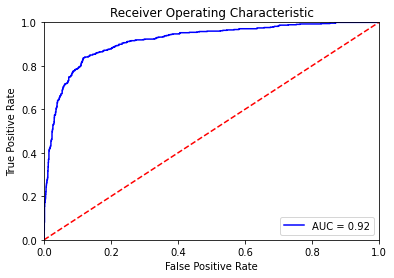

In [34]:
# prédiction sur le jeux de test
probs = bert_predict(bert_classifier, val_discri_dataloader)
# evalutaion du classifieur
evaluate_roc(probs, y_discri_val)

### **3.5. entrainement de notre modèle sur tous le dataset (trian +val)**¶


In [35]:
# Concatenation de training set et du validation set
full_train_data = torch.utils.data.ConcatDataset([train_discri_data, val_discri_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# entrainement sur tous le dataset
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=4)
train(bert_classifier, full_train_dataloader, epochs=4)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.582839   |     -      |     -     |   8.86   
   1    |   40    |   0.412828   |     -      |     -     |   8.48   
   1    |   60    |   0.397053   |     -      |     -     |   8.52   
   1    |   80    |   0.386111   |     -      |     -     |   8.60   
   1    |   100   |   0.375520   |     -      |     -     |   8.66   
   1    |   120   |   0.321995   |     -      |     -     |   8.71   
   1    |   140   |   0.395715   |     -      |     -     |   8.80   
   1    |   160   |   0.332135   |     -      |     -     |   8.88   
   1    |   180   |   0.367693   |     -      |     -     |   8.98   
   1    |   200   |   0.315409   |     -      |     -     |   8.96   
   1    |   220   |   0.381190   |     -      |     -     |   8.95   
   1    |   240   |   0.373051   |     -      |     -     |   8.82   


### **4. Predictions sur le jeu de Test**


In [36]:
# Lancement du `preprocessing_for_bert` sur notre jeu de test
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(data_test.Tweets)

# Creation du DataLoader pour notre jeu de test
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


>>>>> La Tokenization à pris : 0:00:01.033647  secondes.


### **4.2. Predictions**

In [37]:
# Calcule de la probabilité sur le jeux de test
probs = bert_predict(bert_classifier, test_dataloader)

#Récupération de la prédiction issue de la softmax fonction (probabilité)
threshold = 0.9
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Nombre de tweet mal prédit
print("Numbre de tweets mal prédit : ", preds.sum())

Numbre de tweets mal prédit :  497
